In [1]:
! pip install livelossplot
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
import math
import matplotlib.image as mpimg
from glob import glob
from PIL import Image
import numpy as np
import pandas as pd
import cv2
import random
import albumentations as A
import keras
import matplotlib.cm as cm
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import seaborn as sns
from livelossplot.inputs.keras import PlotLossesCallback
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from tensorflow.keras import layers, models
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, precision_score, f1_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# **Display 25 images**

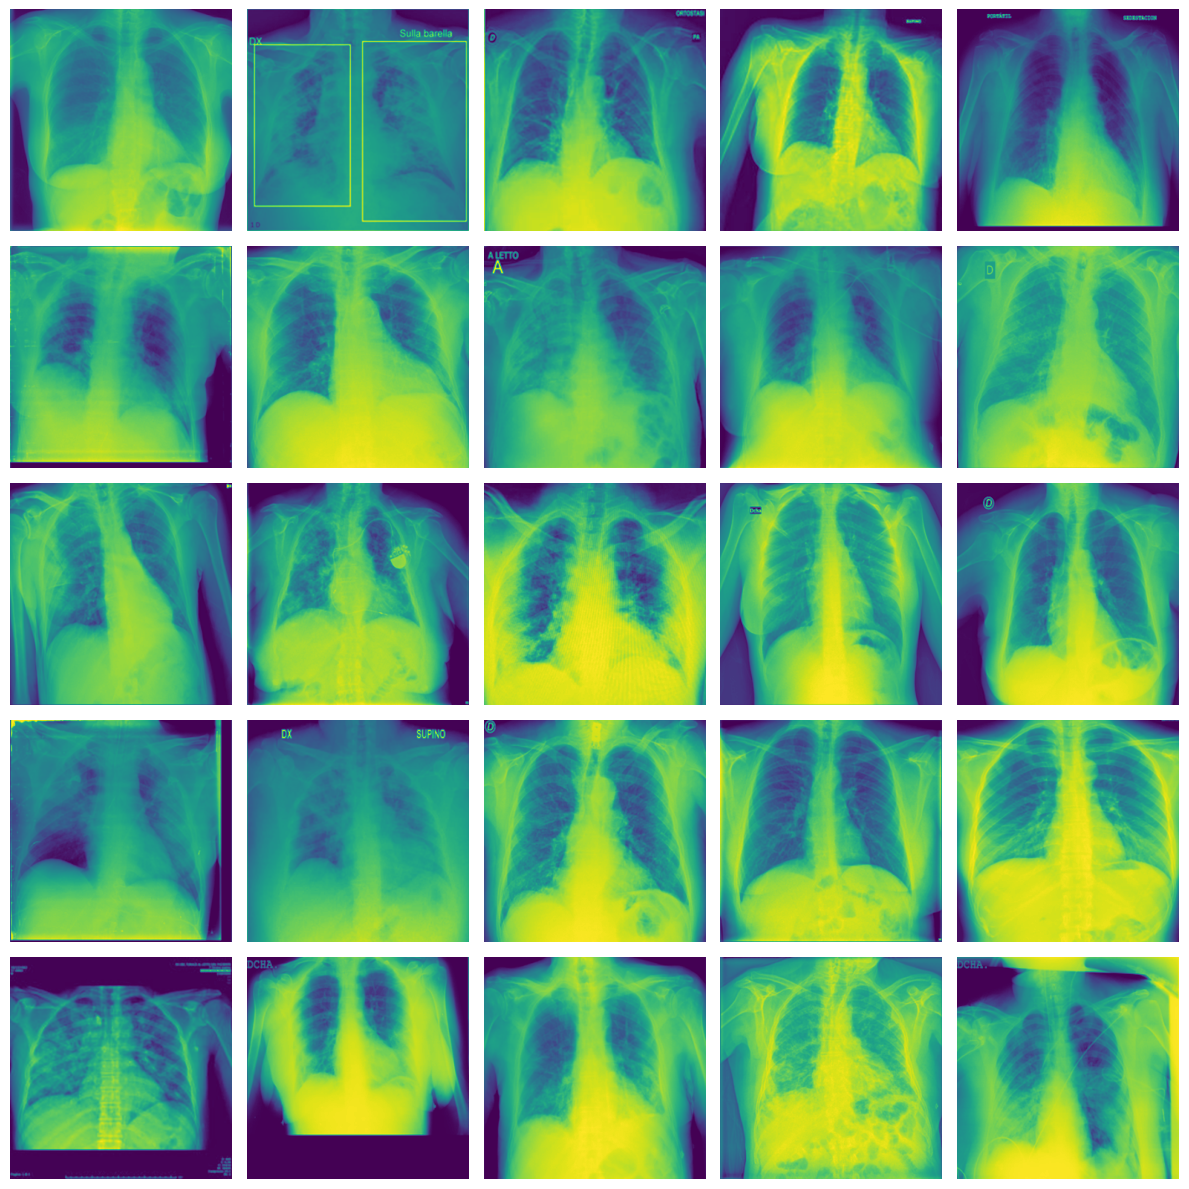

In [2]:
path = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images"

files = os.listdir(path)
num_images = 25  
num_rows = num_cols = int(math.ceil(math.sqrt(num_images)))
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

for i in range(num_images):
    img_path = os.path.join(path, files[i])
    img = mpimg.imread(img_path)
    row = i // num_cols
    col = i % num_cols
    axes[row, col].imshow(img)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# **Display 25 corresponding masks**

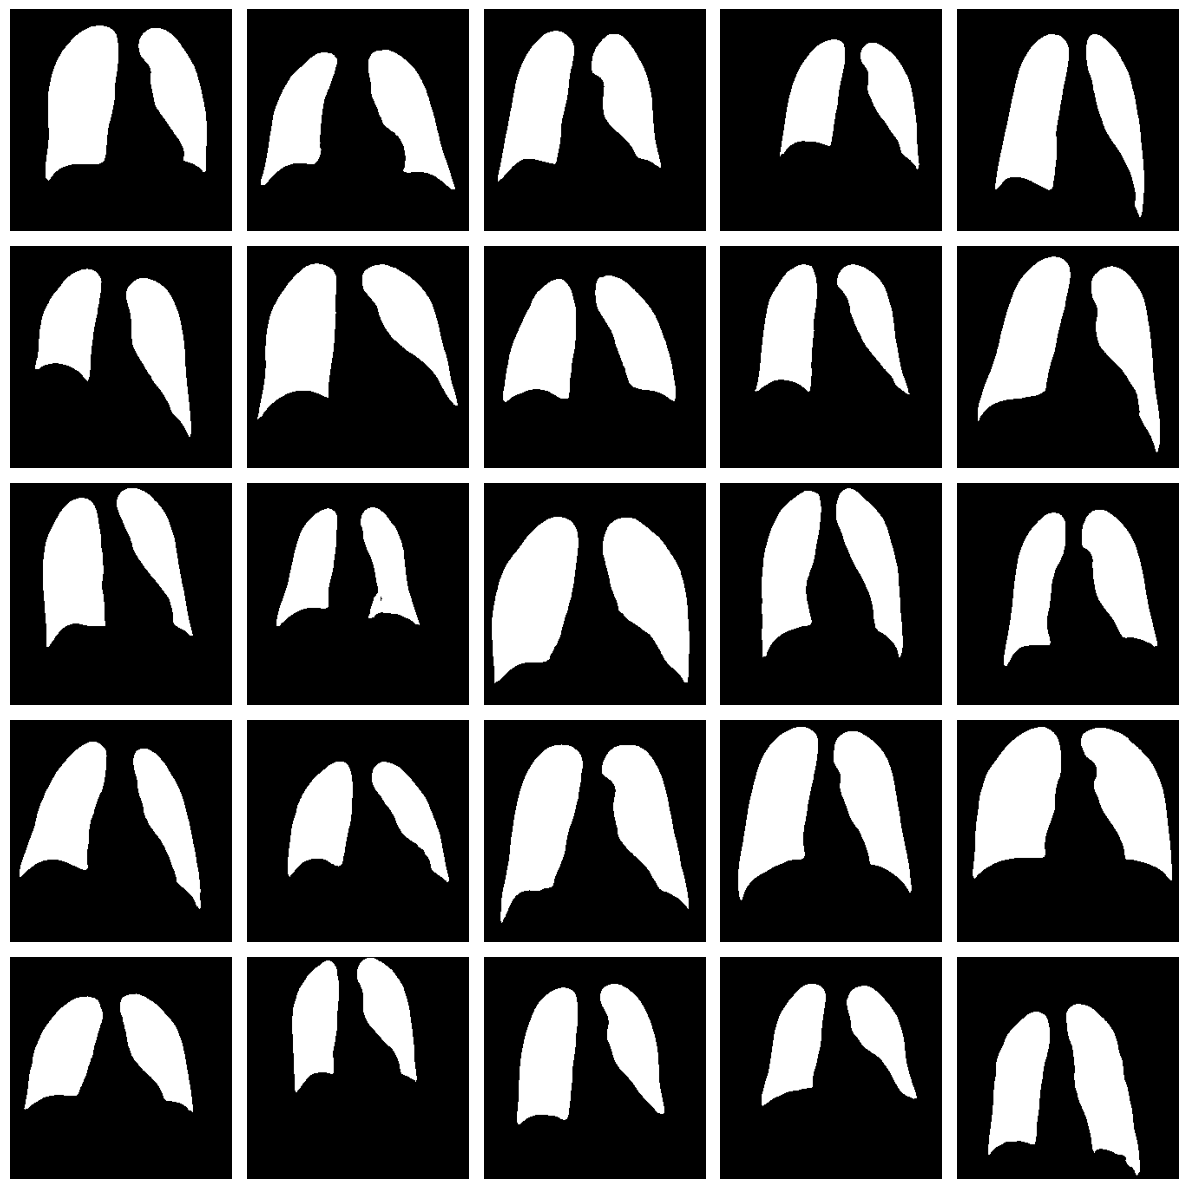

In [3]:
path = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/masks"
files = os.listdir(path)
num_images = 25  
num_rows = num_cols = int(math.ceil(math.sqrt(num_images)))
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

for i in range(num_images):
    img_path = os.path.join(path, files[i])
    img = mpimg.imread(img_path)
    row = i // num_cols
    col = i % num_cols
    axes[row, col].imshow(img)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [5]:
files = ['Normal', 'COVID', 'Lung_Opacity','Viral Pneumonia']
path = "../input/covid19-radiography-database/COVID-19_Radiography_Dataset"
data_dir = os.path.join(path)

data = []
for id, level in enumerate(files):
    for file in os.listdir(os.path.join(data_dir, level+'/'+'images')):
        data.append([level +'/' +'images'+ '/'+file, level])
        

data = pd.DataFrame(data, columns = ['image_file', 'corona_result'])

data['path'] = path + '/' +data['image_file']
data['corona_result'] = data['corona_result'].map({'Normal': 'Normal', 'COVID': 'Covid_positive', 'Lung_Opacity':'Lung_Opacity', 'Viral Pneumonia':'Viral_Pneumonia'})

data.head()

,image_file,corona_result,path
0,Normal/images/Normal-859.png,Normal,../input/covid19-radiography-database/COVID-19...
1,Normal/images/Normal-158.png,Normal,../input/covid19-radiography-database/COVID-19...
2,Normal/images/Normal-10121.png,Normal,../input/covid19-radiography-database/COVID-19...
3,Normal/images/Normal-1811.png,Normal,../input/covid19-radiography-database/COVID-19...
4,Normal/images/Normal-97.png,Normal,../input/covid19-radiography-database/COVID-19...


In [6]:
all_data = []

# Storing images and their labels into a list for further Train Test split
{'Normal': 'Normal', 'COVID': 'Covid_positive', 'Lung_Opacity':'Lung_Opacity', 'Viral Pneumonia':'Viral_Pneumonia'}
for i in range(len(data)):
    image = cv2.imread(data['path'][i])
    image = cv2.resize(image, (70, 70)) / 255.0
    label = 0
    if data['corona_result'][i] == "Normal":
        label = 0
    elif data['corona_result'][i] == "Covid_positive":
        label = 1
    elif data['corona_result'][i] == "Lung_Opacity":
        label = 2
    else:
        label = 3
    label = 1 if data['corona_result'][i] == "Positive" else 0
    all_data.append([image, label])

In [7]:
x = []
y = []

for image, label in all_data:
    x.append(image)
    y.append(label)

# Converting to Numpy Array    
x = np.array(x)
y = np.array(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 42)

print(x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape)

(15238, 70, 70, 3) (4233, 70, 70, 3) (1694, 70, 70, 3) (15238,) (4233,) (1694,)


In [8]:
def create_model(n_classes, train_shape):
    cnn_model = models.Sequential()
    cnn_model.add(layers.Conv2D(filters = 256, kernel_size = (3, 3), activation = 'relu', input_shape = train_shape))
    cnn_model.add(layers.MaxPooling2D((2, 2)))
    cnn_model.add(layers.Dropout(0.3))

    cnn_model.add(layers.Conv2D(filters = 256, kernel_size = (3, 3), activation = 'relu'))
    cnn_model.add(layers.MaxPooling2D((2, 2)))
    cnn_model.add(layers.Dropout(0.5))
    
    cnn_model.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
    cnn_model.add(layers.MaxPooling2D((2, 2)))
    cnn_model.add(layers.Dropout(0.5))
    
    cnn_model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    cnn_model.add(layers.MaxPooling2D((2, 2)))
    cnn_model.add(layers.Dropout(0.5))

    cnn_model.add(layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
    cnn_model.add(layers.Flatten())
    cnn_model.add(layers.Dense(units = 16, activation = 'relu'))
    cnn_model.add(layers.Dropout(0.2))

    cnn_model.add(layers.Dense(units = 4))

    cnn_model.compile(optimizer = 'adam', 
               loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
               metrics = ['accuracy'])

    cnn_model.summary()
    return cnn_model

In [9]:
input_shape = (70, 70, 3)
n_classes= 4

conv_model = create_model(n_classes, input_shape)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 68, 68, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2  (None, 34, 34, 256)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 34, 34, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 256)       590080    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 256)       0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 256)       0

In [11]:
plot_loss_1 = PlotLossesCallback()

tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

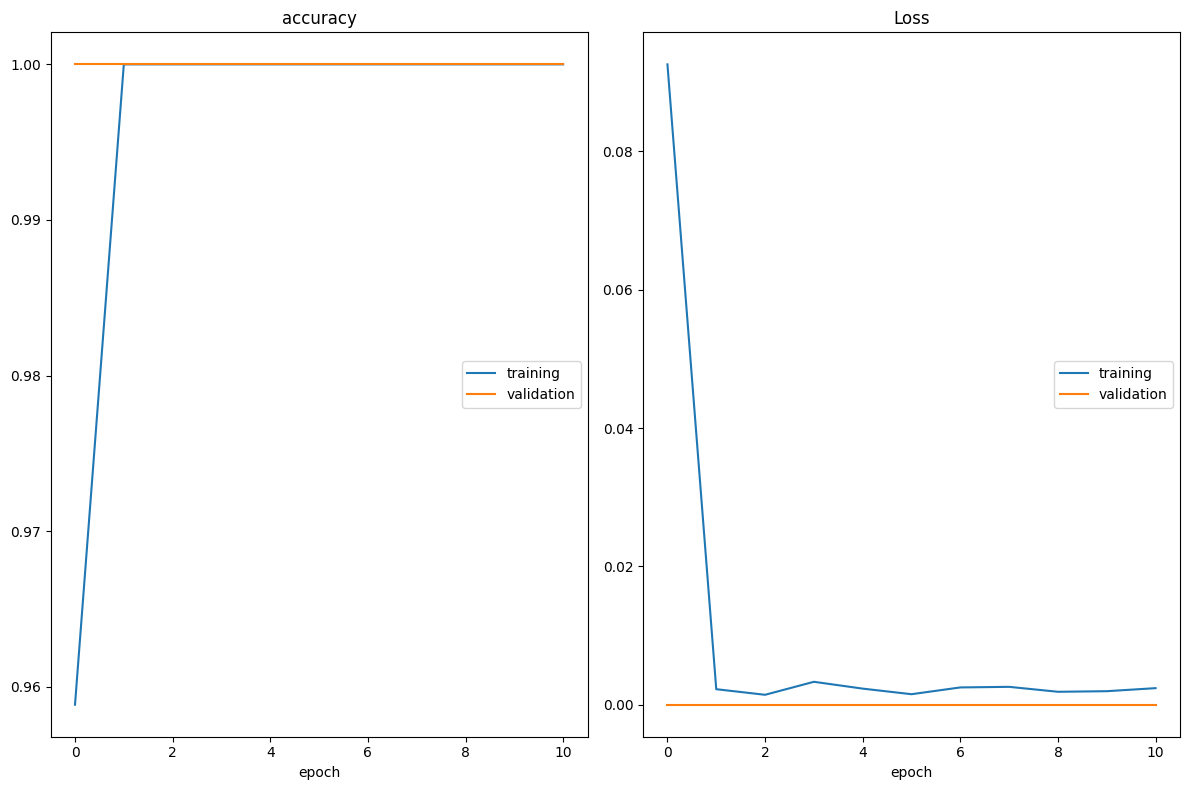

accuracy
	training         	 (min:    0.959, max:    1.000, cur:    1.000)
	validation       	 (min:    1.000, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    0.001, max:    0.093, cur:    0.002)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
60/60 [==============================] - 16s 266ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
CPU times: user 2min 29s, sys: 8.89 s, total: 2min 38s
Wall time: 3min 16s


In [12]:
%%time

plot_loss_2 = PlotLossesCallback()

conv_history = conv_model.fit(x_train, y_train, 
                        epochs = 50, batch_size = 256,  
                        validation_data = (x_val, y_val), 
                        callbacks = [tl_checkpoint_1, early_stop, plot_loss_2],
                       verbose=1)